# Logistic Regression

Currently, **Concrete** only supports unsigned integers up to 7-bits. Nevertheless, we want to evaluate a logistic regression model with it. Luckily, we can make use of **quantization** to overcome this limitation.

### Let's start by importing some libraries to develop our logistic regression model.

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from copy import deepcopy
from typing import Any, Dict

from tqdm import tqdm

### Now import Concrete quantization tools. 

In [2]:
from concrete.quantization import (
    QuantizedArray,
    QuantizedLinear,
    QuantizedModule,
    QuantizedSigmoid,
)

### And some helpers for visualization.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### And, finally, the FHE compiler.

In [4]:
import concrete.numpy as hnp

### Define our Quantized Logistic Regression model.

In [5]:
class QuantizedLogisticRegression(QuantizedModule):
    """
    Quantized Logistic Regression
    Building on top of QuantizedModule, this class will chain together a linear transformation
    and an inverse-link function, in this case the logistic function
    """

    @staticmethod
    def from_sklearn(sklearn_model, calibration_data):
        """Create a Quantized Logistic Regression initialized from a sklearn trained model"""
        if sklearn_model.coef_.ndim == 1:
            weights = np.expand_dims(sklearn_model.coef_, 1)
        else:
            weights = sklearn_model.coef_.transpose()

        bias = sklearn_model.intercept_
        # In our case we have two data dimensions, the precision of the weights  needs to be 2 bits, 
        # as for now we need the quantized values to be greater than zero for weights
        # Thus, to insure a maximum of 7 bits in the output of the linear transformation, we choose
        # 4 bits for the data and the minimum of 1 for the bias
        return QuantizedLogisticRegression(4, 2, 1, 6, weights, bias, calibration_data)

    def __init__(self, q_bits, w_bits, b_bits, out_bits, weights, bias, calibration_data) -> None:
        """
        Create the Logistic regression with different quantization bit precisions:

        Quantization Parameters - Number of bits:
            q_bits (int): bits for input data, insuring that the number of bits of
                        the w . x + b operation does not exceed 7 for the calibration data
            w_bits (int): bits for weights: in the case of a univariate regression this
                        can be 1
            b_bits (int): bits for bias (this is a single value so a single bit is enough)
            out_bits (int): bits for the result of the linear transformation (w.x + b).
                            In the case of Logistic Regression the result of the linear
                            transformation is input to a univariate inverse-link function, so
                            this value can be 7

        Other parameters:
            weights: a numpy nd-array of weights (Nxd) where d is the data dimensionality
            bias: a numpy scalar
            calibration_data: a numpy nd-array of data (Nxd)
        """
        self.n_bits = out_bits

        # We need to calibrate to a sufficiently low number of bits
        # so that the output of the Linear layer (w . x + b)
        # does not exceed 7 bits
        self.q_calibration_data = QuantizedArray(q_bits, calibration_data)

        # Quantize the weights and create the quantized linear layer
        q_weights = QuantizedArray(w_bits, weights)
        q_bias = QuantizedArray(b_bits, bias)
        q_layer = QuantizedLinear(out_bits, q_weights, q_bias)

        # Store quantized layers
        quant_layers_dict: Dict[str, Any] = {}

        # Calibrate the linear layer and obtain calibration_data for the next layers
        calibration_data = self._calibrate_and_store_layers_activation(
            "linear", q_layer, calibration_data, quant_layers_dict
        )

        # Add the inverse-link for inference.
        # This needs to be quantized since it's computed in FHE,
        # but we can use 7 bits of output since, in this case,
        # the result of the inverse-link is not processed by any further layers
        # Seven bits is the maximum precision but this could be lowered to improve speed
        # at the possible expense of higher deviance of the regressor
        q_logit = QuantizedSigmoid(n_bits=7)

        # Now calibrate the inverse-link function with the linear layer's output data
        calibration_data = self._calibrate_and_store_layers_activation(
            "invlink", q_logit, calibration_data, quant_layers_dict
        )

        # Finally construct our Module using the quantized layers
        super().__init__(quant_layers_dict)

    def _calibrate_and_store_layers_activation(
        self, name, q_function, calibration_data, quant_layers_dict
    ):
        """
        This function calibrates a layer of a quantized module (e.g. linear, inverse-link,
        activation, etc) by looking at the input data, then computes the output of the quantized
        version of the layer to be used as input to the following layers
        """

        # Calibrate the output of the layer
        q_function.calibrate(calibration_data)
        # Store the learned quantized layer
        quant_layers_dict[name] = q_function
        # Create new calibration data (output of the previous layer)
        q_calibration_data = QuantizedArray(self.n_bits, calibration_data)
        # Dequantize to have the value in clear and ready for next calibration
        return q_function(q_calibration_data).dequant()

    def quantize_input(self, x):
        q_input_arr = deepcopy(self.q_calibration_data)
        q_input_arr.update_values(x)
        return q_input_arr



### We need a training set, specifically a handcrafted one for simplicity. Let's also define a grid on which to test our classifier.

In [6]:
X, y = make_classification(
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=2,
    n_clusters_per_class=1,
    n_samples=100,
)

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

b_min = np.min(X, axis=0)
b_max = np.max(X, axis=0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

x_test_grid, y_test_grid = np.meshgrid(
    np.linspace(b_min[0], b_max[0], 30), np.linspace(b_min[1], b_max[1], 30)
)
x_grid_test = np.vstack([x_test_grid.ravel(), y_test_grid.ravel()]).transpose()


### Train a logistic regression with sklearn on the training set.

In [7]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

### Let's visualize our data set and initial classifier to get a grasp on it.

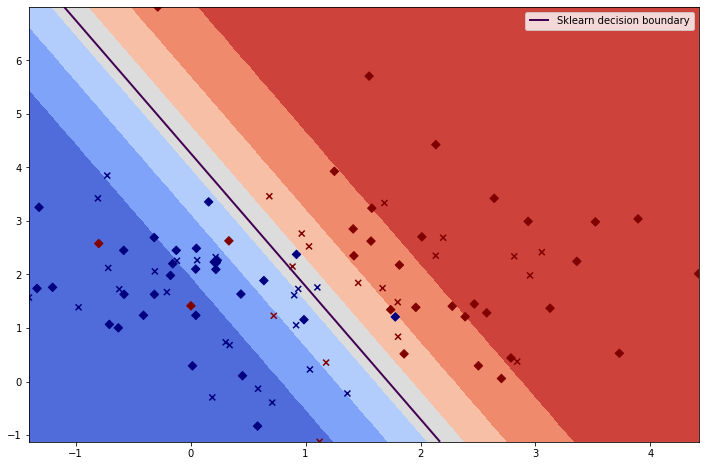

In [8]:
y_score_grid = logreg.predict_proba(x_grid_test)[:,1]

plt.ioff()
plt.clf()
fig, ax = plt.subplots(1, figsize=(12,8))
fig.patch.set_facecolor('white')
ax.contourf(x_test_grid, y_test_grid, y_score_grid.reshape(x_test_grid.shape), cmap='coolwarm')
CS1 = ax.contour(
    x_test_grid,
    y_test_grid,
    y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
)
CS1.collections[0].set_label("Sklearn decision boundary")
ax.scatter(x_train[:,0], x_train[:,1],c=y_train, marker="D", cmap="jet")
ax.scatter(x_test[:,0], x_test[:,1], c=y_test, marker="x", cmap="jet")
ax.legend(loc="upper right")
display(fig)

### Calibrate the model for quantization using both training and test data


In [9]:
calib_data = X 
q_logreg = QuantizedLogisticRegression.from_sklearn(logreg, calib_data)

### Now, we can compile our model to FHE, taking as the possible input set all of our dataset.

In [10]:
X_q = q_logreg.quantize_input(X)

engine = q_logreg.compile(X_q)

### Time to make some predictions, first in the clear.

In [11]:
# Test the original classifier
y_pred_test = np.asarray(logreg.predict(x_test))

# Now that the model is quantized, predict on the test set
x_test_q = q_logreg.quantize_input(x_test)
q_y_score_test = q_logreg.forward_and_dequant(x_test_q)
q_y_pred_test = (q_y_score_test > 0.5).astype(np.int32)

# Predict sklearn classifier probabilities on the domain
y_score_grid = logreg.predict_proba(x_grid_test)[:, 0]

# Predict quantized classifier probabilities on the whole domain to plot contours
grid_test_q = q_logreg.quantize_input(x_grid_test)
q_y_score_grid = q_logreg.forward_and_dequant(grid_test_q)
q_y_pred_test = (q_y_score_test > 0.5).astype(np.int32)


### Now let's predict using the quantized FHE classifier.

In [12]:
non_homomorphic_correct = 0
homomorphic_correct = 0

# Track the samples that are wrongly classified due to quantization issues
q_wrong_predictions = np.zeros((0, 2), dtype=X.dtype)

# Predict the FHE quantized classifier probabilities on the test set.
# Compute FHE quantized accuracy, clear-quantized accuracy and 
# keep track of samples wrongly classified due to quantization
for i, x_i in enumerate(tqdm(x_test_q.qvalues)):
    y_i = y_test[i]

    fhe_in_sample = np.expand_dims(x_i, 1).transpose([1, 0]).astype(np.uint8)

    q_pred_fhe = engine.run(fhe_in_sample)
    y_score_fhe = q_logreg.dequantize_output(q_pred_fhe)
    homomorphic_prediction = (y_score_fhe > 0.5).astype(np.int32)

    non_homomorphic_prediction = q_y_pred_test[i]
    if non_homomorphic_prediction == y_i:
        non_homomorphic_correct += 1
    elif y_pred_test[i] == y_i:
        q_wrong_predictions = np.vstack((q_wrong_predictions, x_test[i, :]))

    if homomorphic_prediction == y_i:
        homomorphic_correct += 1

100%|██████████| 40/40 [01:11<00:00,  1.80s/it]


### Aggregate accuracies for all the versions of the classifier.

In [13]:
sklearn_acc = np.sum(y_pred_test == y_test) / len(y_test) * 100
non_homomorphic_accuracy = (non_homomorphic_correct / len(y_test)) * 100
homomorphic_accuracy = (homomorphic_correct / len(y_test)) * 100
difference = abs(homomorphic_accuracy - non_homomorphic_accuracy)

print(f"Sklearn accuracy: {sklearn_acc:.4f}")
print(f"Non Homomorphic Accuracy: {non_homomorphic_accuracy:.4f}")
print(f"Homomorphic Accuracy: {homomorphic_accuracy:.4f}")
print(f"Difference Percentage: {difference:.2f}%")


Sklearn accuracy: 90.0000
Non Homomorphic Accuracy: 85.0000
Homomorphic Accuracy: 85.0000
Difference Percentage: 0.00%


### Plot the results of both the original and FHE versions of the classifier, showing classification errors induced by quantization with a red circle.

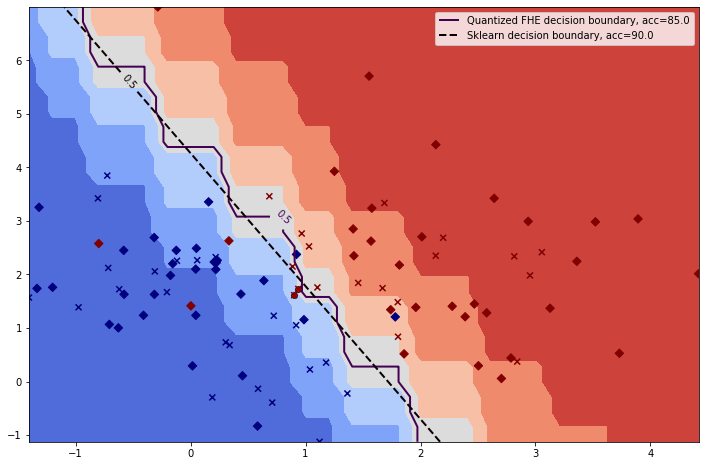

In [14]:
plt.clf()
fig, ax = plt.subplots(1,figsize=(12,8))
fig.patch.set_facecolor('white')
ax.contourf(x_test_grid, y_test_grid, q_y_score_grid.reshape(x_test_grid.shape), cmap="coolwarm")
CS1 = ax.contour(
    x_test_grid,
    y_test_grid,
    q_y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
)
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="jet", marker="D")
ax.scatter(
    q_wrong_predictions[:, 0], q_wrong_predictions[:, 1], c="red", marker="o", edgecolors="k", s=32
)
ax.scatter(x_test[:, 0], x_test[:, 1], c=q_y_pred_test, cmap="jet", marker="x")
CS2 = ax.contour(
    x_test_grid,
    y_test_grid,
    y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
    linestyles="dashed",
    cmap="hot",
)
ax.clabel(CS1, CS1.levels, inline=True, fontsize=10)
ax.clabel(CS2, CS2.levels, inline=True, fontsize=10)
CS1.collections[0].set_label(f"Quantized FHE decision boundary, acc={homomorphic_accuracy:.1f}")
CS2.collections[0].set_label(f"Sklearn decision boundary, acc={sklearn_acc:.1f}")
ax.legend(loc="upper right")
display(fig)

### Enjoy!